<a href="https://colab.research.google.com/github/Nadiam75/DeepLearning_HW_2/blob/main/deepPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## imports

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import progressbar
import tensorflow as tf
import scipy

!rm -d -f -r rm *.zip
!rm -d -f -r rm *.npy

!rm -rf images
!rm -rf visualized


In [29]:
!wget -nc https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/joints.mat
poses=scipy.io.loadmat('joints.mat')['joints']

!wget  -nc https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/images.zip
!unzip -q /content/images.zip


File ‘joints.mat’ already there; not retrieving.

--2021-12-26 13:16:12--  https://github.com/Nadiam75/DeepLearning_HW_2/raw/main/lsp_dataset/images.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_2/main/lsp_dataset/images.zip [following]
--2021-12-26 13:16:12--  https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_2/main/lsp_dataset/images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10319538 (9.8M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]   9.84M  --.-KB/s    in 0.1s    

2021-12-26 13:16:12 (99.5 MB/s) 

## functions

In [77]:

def test_pcp(model , joint_index ) :
  joint_index =['Right elbow','Right wrist']

  name2index={'Right ankle':0,
  'Right knee':1,
  'Right hip':2,
  'Left hip':3,
  'Left knee':4,
  'Left ankle':5,
  'Right wrist':6,
  'Right elbow':7,
  'Right shoulder':8,
  'Left shoulder':9,
  'Left elbow':10,
  'Left wrist':11,
  'Neck':12,
  'Head top':13}


  min_d,max_d=0,1
  pred=model.predict(my_dataset['test images'])
  true=my_dataset['test poses']

  pred_x,pred_y=pred[:,:14],pred[:,14:]
  true_x,true_y=true[:,0],true[:,1]

  true_R_ELBOW_x = true_x [7]
  true_R_ELBOW_Y = true_x [7]
  true_R_WRIST_X = true_y [6]
  true_R_WRIST_y = true_y [6]
  true_distance =  np.sqrt( (true_R_ELBOW_x-true_R_WRIST_X)**2 + (true_R_ELBOW_Y-true_R_WRIST_y)**2)
  distance=np.sqrt((pred_x-true_x)**2+(pred_y-true_y)**2)


  arr=[[]for _ in joint_index]
  for x in np.arange(min_d,max_d,0.001):
    for idx,joint in enumerate(joint_index):
      arr[idx].append(np.sum(distance<x,axis=0)[name2index[joint]]/pred.shape[0])
  for idx,joint in enumerate(joint_index):
    plt.plot(np.arange(min_d,max_d,0.001),arr[idx],label=joint)
  plt.legend()
  plt.show()

In [78]:
def test_pdj(model,joint_index):
  joint_index=['Right elbow','Right wrist']
  name2index={'Right ankle':0,
  'Right knee':1,
  'Right hip':2,
  'Left hip':3,
  'Left knee':4,
  'Left ankle':5,
  'Right wrist':6,
  'Right elbow':7,
  'Right shoulder':8,
  'Left shoulder':9,
  'Left elbow':10,
  'Left wrist':11,
  'Neck':12,
  'Head top':13}
  min_d,max_d=0,1
  pred=model.predict(my_dataset['test images'])
  true=my_dataset['test poses']

  pred_x,pred_y=pred[:,:14],pred[:,14:]
  true_x,true_y=true[:,0],true[:,1]

  distance=np.sqrt((pred_x-true_x)**2+(pred_y-true_y)**2)
  arr=[[]for _ in joint_index]
  for x in np.arange(min_d,max_d,0.001):
    for idx,joint in enumerate(joint_index):
      arr[idx].append(np.sum(distance<x,axis=0)[name2index[joint]]/pred.shape[0])
  for idx,joint in enumerate(joint_index):
    plt.plot(np.arange(min_d,max_d,0.001),arr[idx],label=joint)
  plt.legend()
  plt.show()

In [30]:
def create_dataset (x_train , y_train ,x_val , y_val ,x_test , y_test , train_reconstruction_coefficient , validation_reconstruction_coefficient,  test_reconstruction_coefficient):
  df=dict()
  df['images']=2*x_train/255.0 -1
  df['poses']=to_relative_coord(y_train, 220)
  df['scale train'] = train_reconstruction_coefficient

  df['val images']=2*x_val/255.0 -1
  df['val poses']=to_relative_coord(y_val , 220)
  df['scale val'] = validation_reconstruction_coefficient

  df['test images']=2*x_test/255.0 -1
  df['test poses']=to_relative_coord(y_test , 220)
  df ['scale test '] = test_reconstruction_coefficient
  return df


In [31]:
def to_relative_coord(coord,size):
  #Change pose scale to [-1, 1] scale
  return coord/size*2-1

In [32]:
def to_absolute_coord(coord,size):
  #Change pose scale to scale on image size
  print((coord+1)/2*size)
  return (coord+1)/2*size

In [147]:
np.array ([[1,2,3] , [4,5,6]] )  + 1

array([[2, 3, 4],
       [5, 6, 7]])

In [167]:
def compare_pose(index,model,istest, data):
  # selected = dictionaryOfImages[1600+index]
  # w   =   selected.shape[0]
  # h   =   selected.shape[1]
  plt.figure(figsize=(10,10))

  # show predicted
  if istest:
    print('predicted')
    predicted_pose=model.predict(data['test images'][index:index+1])
    pose_width,pose_height= to_absolute_coord(predicted_pose[0][:14] , 220 )   , to_absolute_coord(predicted_pose[0][14:] , 220)

  else:
    predicted_pose=to_absolute_coord(model.predict(data['images'][index:index+1]),220)
    
  # pose_width,pose_height= (predicted_pose[0][:14] +1 ) *110  , (predicted_pose[0][14:]+1)*110)
  plt.scatter(pose_width,pose_height,c='g',label='Predicted')
  # print(predicted_pose.shape)
  # plt.scatter( (predicted_pose[0][:14]+1),(predicted_pose[0][14:]+1,c='g',label='Predicted')

  if istest:
    # plt.imshow(np.uint8 ( (self.data['test images'][index: index+1]  + 1 )*255   ) [0]   ) 
    # plt.imshow(testDict[1600+index])
    # plt.imshow(x_test[index] )
    plt.imshow(x_test[index] )

  else:
    # plt.imshow(dictionaryOfImages[1600+index] )
    # plt.imshow(trainDict[index])
    plt.imshow(x_train[index] )



  if istest:
    print('actual')
    plt.scatter(to_absolute_coord(data['test poses'][index][0],220),to_absolute_coord(data['test poses'][index][1],220),c='r',label='True')

    # plt.scatter((data['test poses'][0 , 0 , index:index+1] +1 ) *110,  (data['test poses'][0 , 1 , index:index+1] +1 ) *110  ,c='r',label='True')
  else:
    plt.scatter(to_absolute_coord(data['poses'][1600 + index][0],220),to_absolute_coord(data['poses'][1600 +index][1],220),c='r',label='True')
  # if test:
  #   print('actual')
  #   plt.scatter(self.to_absolute_coord(dataset.data['test poses'][index][0],220),self.to_absolute_coord(dataset.data['test poses'][index][1],220),c='r',label='True')
  # else:
  #   plt.scatter(self.to_absolute_coord(dataset.data['poses'][index][0],220),self.to_absolute_coord(dataset.data['poses'][index][1],220),c='r',label='True')
  plt.legend()
  plt.show()



In [168]:
def draw_pose(image_name , model):
  #Model draw pose on new image
  img=plt.imread(image_name)

  img_resized=cv2.resize(img,(220,220),interpolation=cv2.INTER_AREA)
  poses=model.predict(np.array([img_resized]))[0]
  poses_x,poses_y=poses[:14],poses[14:]
  poses_x=to_absolute_coord(poses_x,img.shape[1])
  poses_y=to_absolute_coord(poses_y,img.shape[0])

  plt.imshow(img)
  plt.scatter(poses_x,poses_y,c='r')
  plt.show()


In [124]:
def define_model(final_op=28):
  #LRN->BN, Pooling->Strided Convolution
  model=tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(48,11,(4,4),padding='same',input_shape=(220,220,3)))
  model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
  #model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.ReLU())

  model.add(tf.keras.layers.Conv2D(128,5,(2,2),padding='same'))
  model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
  #model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.ReLU())

  model.add(tf.keras.layers.Conv2D(192,3,(2,2),padding='same',activation='relu'))
  model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
  model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(4096,activation='relu'))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(4096,activation='relu'))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(final_op,activation='linear'))
  return model

## display data

if we try to display some of the  images with their corresponding joints:

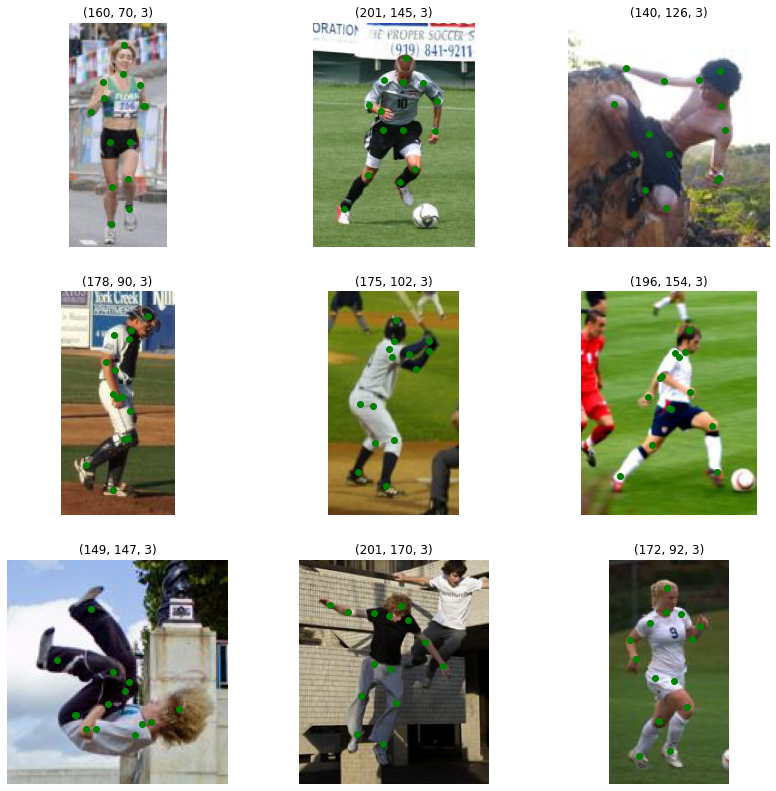

In [36]:
plt.figure(figsize=(14,14))
for idx in range(9):
  # idx = 1
  plt.subplot(3,3 , idx+1)
  image = plt.imread(f'images/im000{idx+1}.jpg')
  plt.axis('off')

  plt.title(str(image.shape))
  plt.imshow(image)
  coordinates = poses [0:2 , : , idx]
  plt.scatter(coordinates[0,:] , coordinates [1 ,: ],c='g',label='Original')

In [37]:
coordinates = poses [0:2 , : , 125]
coordinates.shape

(2, 14)

In [38]:
poses [0 , : , 125]
# pahnaye tasvir  70 dim 0 joints width

array([68.83965066, 54.03207011, 40.16965427, 35.7588856 , 42.37503861,
       21.58141485, 73.88052915, 55.29228973, 52.77185049, 53.7170152 ,
       56.55250935, 75.77085858, 58.12778388, 57.49767407])

In [39]:
poses [1, : , 125]
#ertefae tasvir 160 dim 1 joints height

array([151.0422136 , 119.53672306,  88.34628743,  84.25057366,
       120.16683287, 148.52177436,  81.73013442,  75.11398141,
        49.90958898,  42.66332615,  68.8128833 ,  73.85376179,
        39.5127771 ,  21.55464749])

# found 1 corrupt sample!

150
154


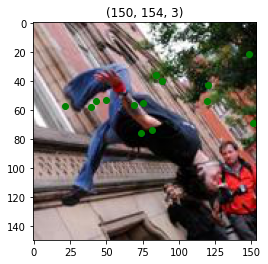

In [41]:
image = plt.imread(f'images/im0125.jpg')
# image = image.transpose((1, 0, 2))
height,width=image.shape[0],image.shape[1]
print(height)   # dim 0 image
print(width)    # dim 1 image
plt.title(str(image.shape))
plt.imshow(image)
coordinates = poses [0:2 , : , 125]
plt.scatter(coordinates[1,:] , coordinates [0 ,: ],c='g',label='Original')

## prepare data

In [61]:
images_directory=os.listdir('/content/images')
target_size=(220,220)
resized_images=[]
resized_poses=[]
std_poses = [] 
widthsnheights = []
originalImages = []
dictionaryOfTrainImages = {}
dictionaryOfTestImages = {}
dictionaryOfImages = {}
# datasetDictionary = {}
for idx,x in enumerate(images_directory):
    if idx+1 < 10 :  
      path = f'/content/images/im000{idx+1}.jpg'
    if idx+1>=10 and idx <100:
      path = f'/content/images/im00{idx+1}.jpg'
    if idx+1 >= 100 and idx <= 999 :
      path = f'/content/images/im0{idx+1}.jpg'
    if idx+1 >= 1000:
      path = f'/content/images/im{idx+1}.jpg'

    image = plt.imread(path)
    dictionaryOfImages [idx ] = image
    height, width=image.shape[0],image.shape[1]

    # looking for corrupt data!
    if  np.any (poses[0,:,idx] > width ):
      print("height " , idx)
    if np.any (poses [1,:,idx] > height ):
      print("width" , idx)

    resized_poses.append(  [ poses[0,:,idx]*220 / width ,    poses[1, : , idx]  *220/ height ])
    std_poses.append (  [ poses[0,:,idx] / width   - 0.5  ,   poses[1, : , idx]  / height - 0.5 ] )
    widthsnheights.append ( [ width  , height])
    image=cv2.resize(image,target_size,interpolation=cv2.INTER_AREA)
    resized_images.append(image)




resized_images=np.array(resized_images)
resized_poses=np.array(resized_poses)


trainkeys = np.arange(0 , 1600)
trainDict = {k: dictionaryOfImages[k] for k in trainkeys}

testkeys = np.arange(1600 , 2000)
testDict = {k: dictionaryOfImages[k] for k in testkeys}


np.save('Leeds Sports Dataset NPY.npy',resized_images[:1400])
np.save('Resized Poses.npy',resized_poses[:1400])
np.save('Leeds Sports Dataset NPY Validation.npy',resized_images[1400:1700])
np.save('Resized Poses Validation.npy',resized_poses[1400:1700])
np.save('Leeds Sports Dataset NPY Test.npy',resized_images[1700:])
np.save('Resized Poses Test.npy',resized_poses[1700:])
x_train = resized_images[:1400]
y_train = resized_poses[:1400]
x_val = resized_images[1400:1700]
y_val = resized_poses[1400:1700]
x_test = resized_images[1700:]
y_test = resized_poses[1700:]
train_reconstruction_coefficient = widthsnheights[:1400]
validation_reconstruction_coefficient =widthsnheights [1400: 1700]
test_reconstruction_coefficient  =widthsnheights[1700:]

width 125


In [62]:
y_train.shape

(1400, 2, 14)

In [63]:
my_dataset = create_dataset (x_train , y_train ,x_val , y_val ,x_test , y_test , train_reconstruction_coefficient , validation_reconstruction_coefficient,  test_reconstruction_coefficient)

In [64]:
resized_poses[:1400].shape

(1400, 2, 14)

## training

In [115]:
y_train_cat=np.concatenate((my_dataset['poses'][:,0],my_dataset['poses'][:,1]),axis=1)
y_val_cat=np.concatenate((my_dataset['val poses'][:,0],my_dataset['val poses'][:,1]),axis=1)
y_test_cat=np.concatenate((my_dataset['test poses'][:,0],my_dataset['test poses'][:,1]),axis=1)


model = define_model()
model.compile(optimizer=tf.keras.optimizers.Adam( learning_rate= 0.002 ),loss=tf.keras.losses.mse)
training_history=model.fit(x=  my_dataset['images'],y= y_train_cat,epochs=50 ,batch_size=64,validation_data=(my_dataset['val images'] ,  y_val_cat) ,verbose=1)

Epoch 1/50
22/22 [==============================] - 7s 269ms/step - loss: 1.8475 - val_loss: 0.0832
Epoch 2/50
22/22 [==============================] - 5s 244ms/step - loss: 0.0853 - val_loss: 0.0828
Epoch 3/50
22/22 [==============================] - 5s 245ms/step - loss: 0.0843 - val_loss: 0.0840
Epoch 4/50
22/22 [==============================] - 5s 245ms/step - loss: 0.0845 - val_loss: 0.0832
Epoch 5/50
22/22 [==============================] - 5s 244ms/step - loss: 0.0845 - val_loss: 0.0823
Epoch 6/50
22/22 [==============================] - 5s 244ms/step - loss: 0.0842 - val_loss: 0.0826
Epoch 7/50
22/22 [==============================] - 5s 244ms/step - loss: 0.0837 - val_loss: 0.0825
Epoch 8/50
22/22 [==============================] - 5s 245ms/step - loss: 0.0839 - val_loss: 0.0822
Epoch 9/50
22/22 [==============================] - 5s 243ms/step - loss: 0.0839 - val_loss: 0.0826
Epoch 10/50
22/22 [==============================] - 5s 244ms/step - loss: 0.0838 - val_loss: 0.0825

In [103]:
model.save('svdmdl')
# model =tf.keras.models.load_model('svdmdl')

INFO:tensorflow:Assets written to: svdmdl/assets


## display

In [143]:
height,width=image.shape[0],image.shape[1]
[poses[0,:,1600+213]/width*220              ,       poses[1,:,1600+213]/height*220   ] 

[array([31.48643704, 49.7328035 , 30.96511228, 30.44378752, 36.6996846 ,
        20.0172924 , 62.7659224 , 53.90340155, 45.04088069, 51.29677777,
        66.41519569, 69.54314423, 49.7328035 , 56.51002533]),
 array([148.60377445, 119.40958811,  85.00215421,  86.04480372,
        114.7176653 , 141.82655262,  35.99762714,  47.98809653,
         42.77484897,  43.29617372,  53.72266884,  43.29617372,
         35.99762714,  19.8365597 ])]

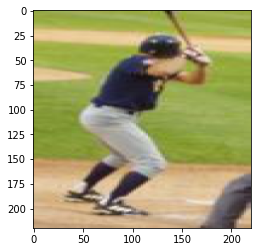

In [144]:
plt.imshow (resized_images[1813])

In [145]:
resized_poses[1600+213 , : , :]

array([[ 76.12105657, 120.23315132,  74.86071101,  73.60036544,
         88.72451221,  48.39345416, 151.74179042, 130.31591583,
        108.89004124, 124.01418801, 160.56420937, 168.12628275,
        120.23315132, 136.61764365],
       [192.31076693, 154.5300552 , 110.0027878 , 111.35209893,
        148.4581551 , 183.54024456,  46.58516453,  62.10224256,
         55.3556869 ,  56.03034246,  69.5234538 ,  56.03034246,
         46.58516453,  25.67084196]])

predicted
[101.741264 103.83115  104.85974  112.568634 113.55793  111.71136
 105.331764 101.81088  104.390335 115.732605 118.74543  119.605446
 109.99588  111.170105]
[175.98074  142.87689  111.22671  111.47459  142.81941  175.87878
  90.27981   82.97541   64.255104  64.920364  84.327255  92.57204
  57.87567   38.038425]
actual
[108.76494268 132.55752349 128.09641459  93.89457968 116.20012418
 122.14826939 168.2463947  138.50566869 132.55752349  73.07607147
  47.79645437 104.30383378 125.12234199 128.09641459]
[197.37054763 149.43499241 110.27636983 107.57577517 144.03380309
 178.46638501 102.84973451  76.51893657  47.48754397  53.56388196
  79.21953123  78.54438257  40.73605732  21.8318947 ]


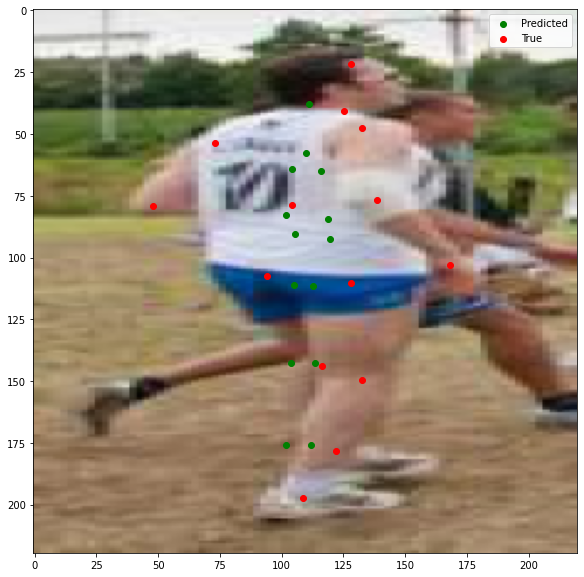

In [169]:
num = 98
compare_pose(num,model,1, my_dataset)# DeepPose.model.predict(DeepPose.data['test images'][index:index+1]),220)
# plt.imshow(  dataset.data['test images'][num] +1 , aspect='auto')
# dataset.compare_pose(100,DeepPose,False)

[80.40221  82.03373  82.78363  89.16038  89.859215 88.383606 83.360825
 80.334526 82.44281  91.39396  93.97217  94.76992  86.798904 87.77738 ]
[163.91931  132.19014  101.961426 102.479225 132.28906  163.99745
  82.42659   75.28045   57.38608   58.11706   76.64855   84.55775
  51.166718  32.281452]


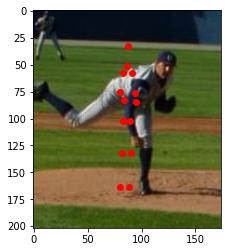

In [120]:
draw_pose('images/im1210.jpg' , model)


predicted
[101.741264 103.83115  104.85974  112.568634 113.55793  111.71136
 105.331764 101.81088  104.390335 115.732605 118.74543  119.605446
 109.99588  111.170105]
[175.98074  142.87689  111.22671  111.47459  142.81941  175.87878
  90.27981   82.97541   64.255104  64.920364  84.327255  92.57204
  57.87567   38.038425]
actual
[170.49030572 144.6459788  138.18489707 113.33458272  94.44834382
  94.94535011 118.30464559 124.26872104 134.20884677  95.44235639
  62.63994146  48.72376542 104.38846956 102.40044441]
[179.89232281 153.4327827  115.91552434 117.89011688 143.55981997
 179.89232281  62.60152561  74.44908089  66.1557922   67.34054772
  83.53220659  71.28973281  60.62693307  38.90641507]


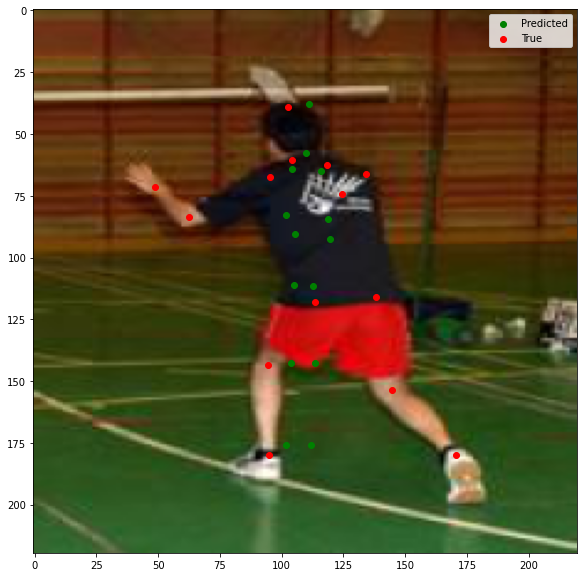

predicted
[101.741264 103.83115  104.85974  112.568634 113.55793  111.71136
 105.331764 101.81088  104.390335 115.732605 118.74543  119.605446
 109.99588  111.170105]
[175.98074  142.87689  111.22671  111.47459  142.81941  175.87878
  90.27981   82.97541   64.255104  64.920364  84.327255  92.57204
  57.87567   38.038425]
actual
[169.96484042 143.46937263 126.43657191  92.37097046  69.6605695
  65.87550267 107.51123777 158.60963994 160.50217335  75.33816974
  48.84270194 124.54403849 120.75897167 113.18883801]
[198.05423395 159.0207323  116.08388047 115.30321044 148.87202187
 194.93155382  87.19908925  87.97975928  51.28826772  59.09496805
  85.63774918  84.85707915  45.82357749  20.06146639]


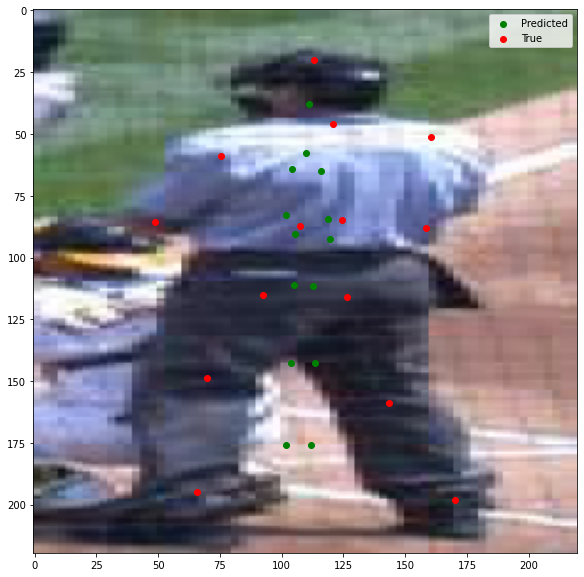

predicted
[101.741264 103.83115  104.85974  112.568634 113.55793  111.71136
 105.331764 101.81088  104.390335 115.732605 118.74543  119.605446
 109.99588  111.170105]
[175.98074  142.87689  111.22671  111.47459  142.81941  175.87878
  90.27981   82.97541   64.255104  64.920364  84.327255  92.57204
  57.87567   38.038425]
actual
[ 76.21391495  95.39044018  96.8655575  118.25475872 118.25475872
  96.12799884 116.77964139  48.18668577  58.51250705 123.41766935
 169.14630643 132.2683733   98.34067483 108.6664961 ]
[197.94367294 151.42718911 107.73941038 106.16790755 153.31299251
 196.68647068  78.82375827  82.90966563  54.62261465  52.10821012
  68.45183957  43.93639539  42.67919313  20.67815348]


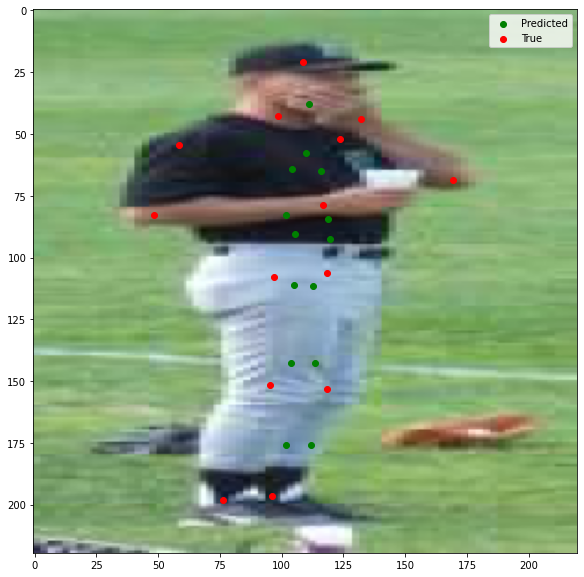

predicted
[101.741264 103.83115  104.85974  112.568634 113.55793  111.71136
 105.331764 101.81088  104.390335 115.732605 118.74543  119.605446
 109.99588  111.170105]
[175.98074  142.87689  111.22671  111.47459  142.81941  175.87878
  90.27981   82.97541   64.255104  64.920364  84.327255  92.57204
  57.87567   38.038425]
actual
[187.25909872 128.71409655  90.50342719 106.36867587 138.32262744
 182.79001459  52.51621204  38.21514281  31.73497081  66.81728127
  93.85524029  73.07399906  48.71749052  38.66205122]
[188.87838988 152.31827723 124.73201041  93.82209698 132.70876226
 194.86095377 118.74944652 116.42289389  73.21548803  50.94705578
  77.53622862 106.45195408  61.91508957  23.69315362]


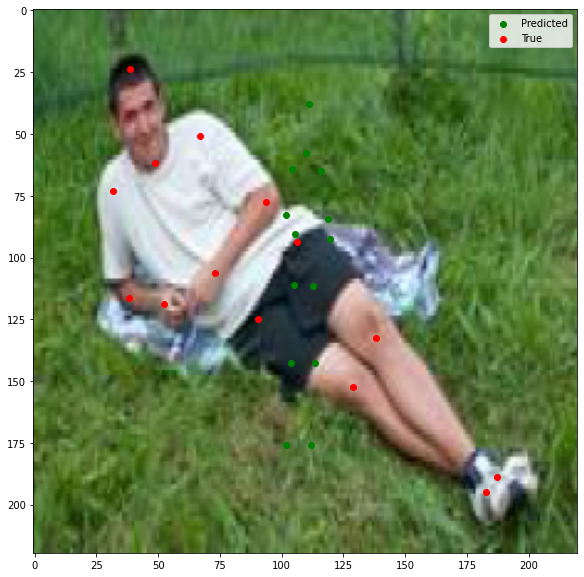

predicted
[101.741264 103.83115  104.85974  112.568634 113.55793  111.71136
 105.331764 101.81088  104.390335 115.732605 118.74543  119.605446
 109.99588  111.170105]
[175.98074  142.87689  111.22671  111.47459  142.81941  175.87878
  90.27981   82.97541   64.255104  64.920364  84.327255  92.57204
  57.87567   38.038425]
actual
[169.87349042 122.92963556  95.63669669  91.26982647  93.45326158
 106.55387224  65.06860515  48.69284182  78.16921581 112.01246001
  98.91184935  53.05971204  84.71952114 113.10417757]
[186.29618135 155.37434893 127.6239865  126.831119   163.30302391
 201.36066382  17.41540428  43.58003171  66.17675541  72.12326164
  74.10543039  52.30157419  63.00528541  44.37289921]


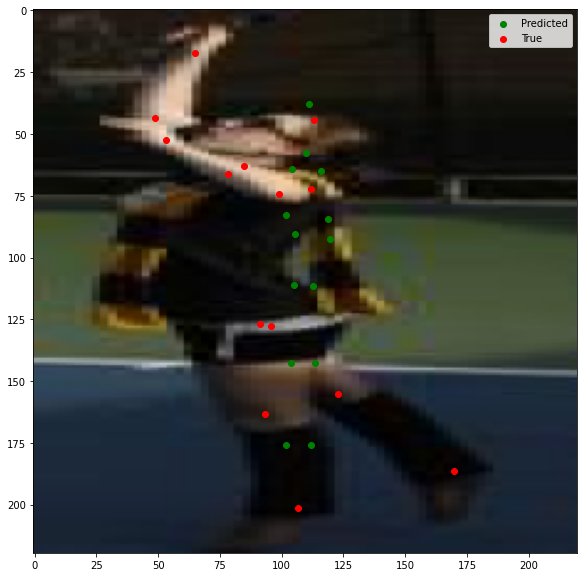

predicted
[101.741264 103.83115  104.85974  112.568634 113.55793  111.71136
 105.331764 101.81088  104.390335 115.732605 118.74543  119.605446
 109.99588  111.170105]
[175.98074  142.87689  111.22671  111.47459  142.81941  175.87878
  90.27981   82.97541   64.255104  64.920364  84.327255  92.57204
  57.87567   38.038425]
actual
[112.03746717 106.29679551 112.03746717 169.44418378 133.08659659
 159.87639768  68.02565109  48.89007889  89.07478052 165.61706934
 138.82726825 104.38323828 125.43236771 135.00015381]
[196.27662587 150.47953574 108.27437425 107.37639209 135.21383903
 176.52101836  46.31360526  61.57930197  57.98737333  57.08939117
  73.25307004  49.00755173  48.10956957  22.96606911]


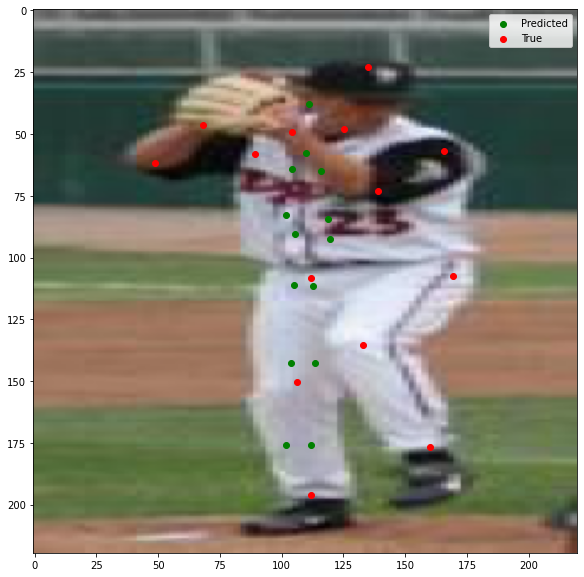

predicted
[101.741264 103.83115  104.85974  112.568634 113.55793  111.71136
 105.331764 101.81088  104.390335 115.732605 118.74543  119.605446
 109.99588  111.170105]
[175.98074  142.87689  111.22671  111.47459  142.81941  175.87878
  90.27981   82.97541   64.255104  64.920364  84.327255  92.57204
  57.87567   38.038425]
actual
[164.08565436  83.95005539  91.23510984 139.80213952 117.94697617
 100.94851578  47.52478312  59.66654054  59.66654054 139.80213952
 168.94235733 144.65884249  91.23510984  96.09181281]
[188.43438372 146.51336863 110.72713623 110.72713623 155.71554267
 197.63655777  89.25539679  71.87351248  48.35684548  55.51409196
  79.03075896 104.59235353  46.31191791  20.75032334]


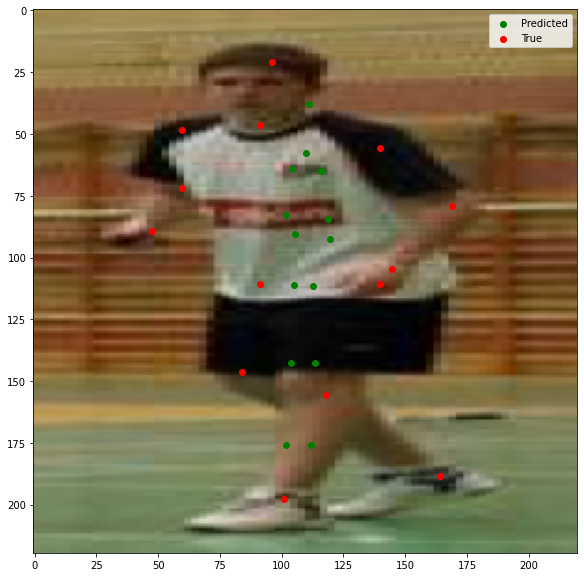

predicted
[101.741264 103.83115  104.85974  112.568634 113.55793  111.71136
 105.331764 101.81088  104.390335 115.732605 118.74543  119.605446
 109.99588  111.170105]
[175.98074  142.87689  111.22671  111.47459  142.81941  175.87878
  90.27981   82.97541   64.255104  64.920364  84.327255  92.57204
  57.87567   38.038425]
actual
[108.2165864   76.50145996  98.58878016 120.10975882 131.43658969
 168.81513157  44.21999197  54.9804813   62.34292137  92.35902318
  86.69560774  54.9804813   77.0678015   73.1034107 ]
[161.50641246 137.66805667 117.16707069 106.20142702 141.00542648
 176.76296016  72.3509618   58.04794833  59.47824967  65.67622218
  97.61961894  88.08427662  63.76915372  41.83786639]


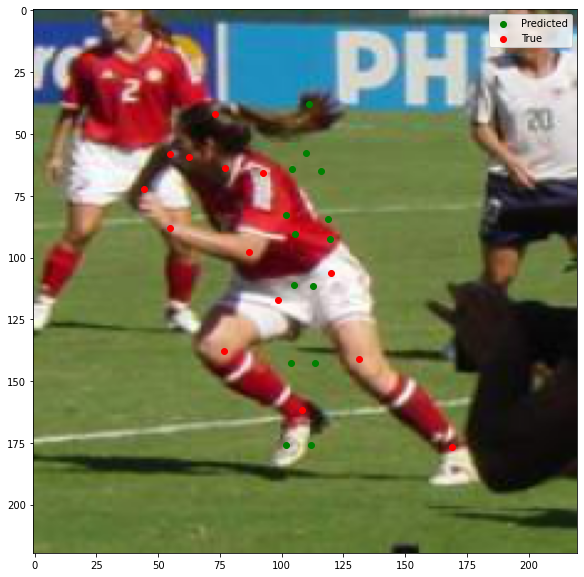

predicted
[101.741264 103.83115  104.85974  112.568634 113.55793  111.71136
 105.331764 101.81088  104.390335 115.732605 118.74543  119.605446
 109.99588  111.170105]
[175.98074  142.87689  111.22671  111.47459  142.81941  175.87878
  90.27981   82.97541   64.255104  64.920364  84.327255  92.57204
  57.87567   38.038425]
actual
[ 35.20631347  27.18704267  89.23087467 100.20461366  47.86832
  48.29038689 185.88419119 166.89118139 155.49537551 146.63197094
 148.74230536 149.16437225 158.4498437  139.03476702]
[126.01574227  58.23947458  75.42910769  54.80154796  48.41682709
 121.5955509   96.5477998  105.87931491 122.57781565 125.52460989
 142.714243   169.23539123 144.18764013 169.7265236 ]


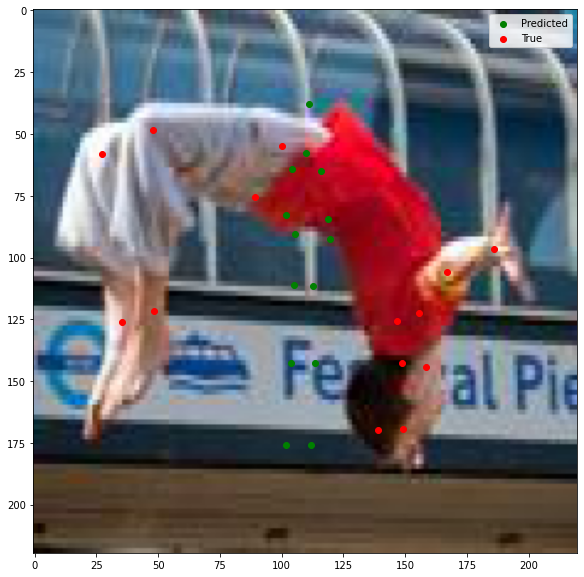

In [171]:
array = [89 ,90,91,92,93,94,95,96 , 97]
# plt.figure(figsize=(14,14))
for idx in range(9):
  # idx = 1
  # plt.subplot(3,3 , idx+1)
  num = array[idx]
  compare_pose(num,model,1, my_dataset)
  # image = plt.imread(f'images/im000{idx+1}.jpg')
  # plt.axis('off')

  # plt.title(str(image.shape))
  # plt.imshow(image)
  # coordinates = poses [0:2 , : , idx]
  # plt.scatter(coordinates[0,:] , coordinates [1 ,: ],c='g',label='Original')

##metrics

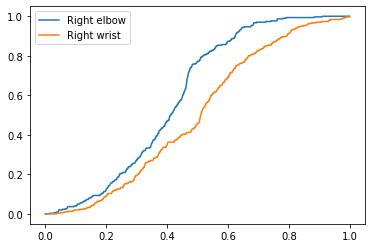

In [110]:
test_pdj(model,['Right wrist','Right elbow'])

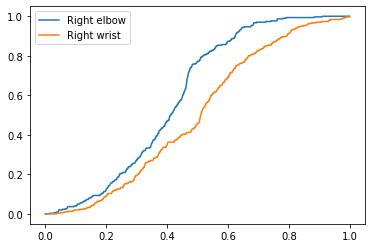

In [101]:
test_pcp(model,['Right wrist','Right elbow'])

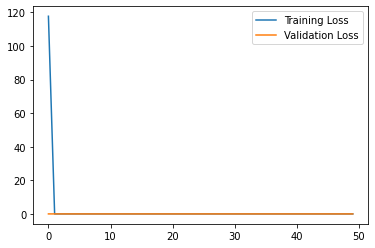

In [102]:
plt.plot(training_history.history['loss'],label='Training Loss')
plt.plot(training_history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()